<a href="https://colab.research.google.com/github/sudip2k17/Sequential-Sentence-Classification/blob/main/SequentialSentenceClassificationCapstoneProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Objective:
Build Deep learning Model for Sequential Sentence Classification, for Converting “Harder to Read” text into “Easier to Read ” text.

Approach:Create many to one model

Use following models

A. Naïve Bayes with TF-IDF encoder (baseline)

B. Conv1D with token embedding

C. Pertained Feature Extractor

D. Conv1D with character embedding



# **Dataset details :**
PubMed 20k RCT is dataset based on PubMed for sequential sentence classification. The dataset consists of approximately 20,000 abstracts of randomized controlled trials. Each sentence of each abstract is labelled with their role in the abstract using one of the following classes: background, objective, method, result, or conclusion. The purpose of releasing this dataset is twofold. First, the majority of datasets for sequential short-text classification i.e., classification of short texts that appear in sequences. Second, from an application perspective, researchers need better tools to efficiently skim through the literature. Automatically classifying each sentence in an abstract would help researchers read abstracts more efficiently, especially in fields where abstracts may be long, such as the medical field.

In [2]:
#storing the PubMed_20k_RCT dataset in reference variable for future use
datafile_directory = "dataset/"

In [3]:
#Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
# TextVectorization is now in keras.layers.preprocessing
from tensorflow.keras.layers import TextVectorization
import random

# **Explore & Preprocess Data**

In [4]:
def get_raw_data(filepath):
    with open(filepath) as f:
        return f.readlines()

train.txt -This contains list of training set.

dev.txt - This contains the development set (i.e validation set)

test.txt - This file contains the test set

In [5]:
#Loading the data
train_data = get_raw_data(datafile_directory + 'train.txt')
#Viewing first 20 records from training dataset file
train_data[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( 0-100 mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .\n',
 'METHODS\tSerum levels of interleukin 1 ( IL-1 ) , IL-6 , tumor necrosis factor ( TNF )

In [8]:
def preprocess_text_with_line_numbers(filename):

  input_lines = get_raw_data(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = ""    # reset the abstract string
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines() # split the abstract into separate lines

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"]   = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line


  return abstract_samples

In [9]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(datafile_directory + "train.txt")
val_samples = preprocess_text_with_line_numbers(datafile_directory + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(datafile_directory + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 638 ms, sys: 98.5 ms, total: 737 ms
Wall time: 732 ms


(180040, 30212, 30135)

In [10]:
train_samples[:15]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of 125 patients with primary knee oa were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( 0-100 mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the weste

In [11]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of 6 weeks of dail...,0,11
1,METHODS,a total of 125 patients with primary knee oa w...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin 1 ( il-1 ) , il-6 ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( 9...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at 12 w...,9,11


In [12]:
# Distribution of labels in training dat
train_df["target"].value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


<Axes: xlabel='target'>

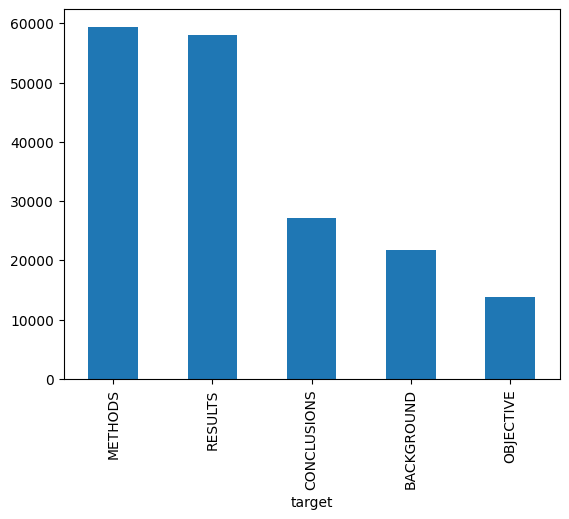

In [13]:
train_df["target"].value_counts().plot(kind = 'bar')

<Axes: ylabel='Frequency'>

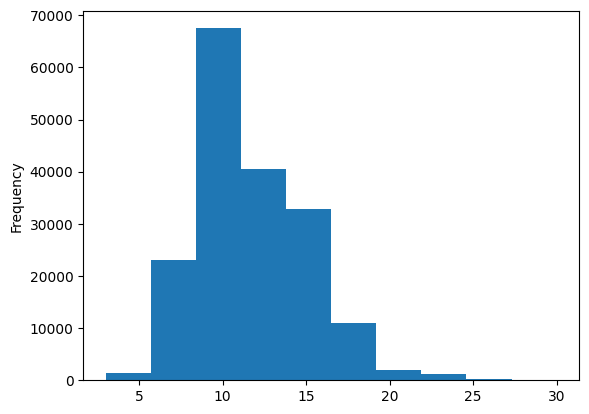

In [14]:
train_df.total_lines.plot(kind= "hist")

In [15]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [17]:
train_sentences[:15]

['to investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of 125 patients with primary knee oa were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( 0-100 mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and 6-min walk distance ( 6mwd ) .',
 'serum levels of interleukin 1 ( il-1 ) , il-6 , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was

**One Hot Encoder**

In [20]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
# Remove the 'sparse' argument
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

<180040x5 sparse matrix of type '<class 'numpy.float64'>'
	with 180040 stored elements in Compressed Sparse Row format>

**Label encode labels**

In [21]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [22]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

**Model 0: Getting a baseline**

First model will be a TF-IDF Multinomial Naive Bayes as recommended by Scikit-Learn's machine learning map.

Will create a Scikit-Learn Pipeline which uses the TfidfVectorizer class to convert our abstract sentences to numbers using the TF-IDF (term frequency-inverse document frequecy) algorithm and then learns to classify our sentences using the MultinomialNB aglorithm.

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded);

In [24]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7317291142592347

In [25]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([0, 1, 3, ..., 4, 4, 1])

In [26]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-03-11 08:30:34--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-03-11 08:30:34 (66.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [27]:
# Import calculate_results helper function
from helper_functions import calculate_results

**Model_0 Results**

In [28]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 73.17291142592347,
 'precision': 0.7315166696974572,
 'recall': 0.7317291142592347,
 'f1': 0.7058060715307974}

# **Prepare Data For Deep Neural Network Models**

When this model goes through sentences, it works best when they're all the same length (this is important for creating batches of the same size tensors)

* Finding the average sentence length in the Dataset.




In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [30]:
sen_len = [len(sentences.split()) for sentences in train_sentences]
avg_sen_len = np.mean(sen_len)
avg_sen_len

26.338435903132638

(array([4.2075e+04, 7.9623e+04, 3.8292e+04, 1.2725e+04, 4.3900e+03,
        1.6450e+03, 7.2600e+02, 2.8900e+02, 1.3600e+02, 5.5000e+01,
        2.9000e+01, 1.5000e+01, 1.1000e+01, 9.0000e+00, 8.0000e+00,
        5.0000e+00, 2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00]),
 array([  1.        ,  15.04761905,  29.0952381 ,  43.14285714,
         57.19047619,  71.23809524,  85.28571429,  99.33333333,
        113.38095238, 127.42857143, 141.47619048, 155.52380952,
        169.57142857, 183.61904762, 197.66666667, 211.71428571,
        225.76190476, 239.80952381, 253.85714286, 267.9047619 ,
        281.95238095, 296.        ]),
 <BarContainer object of 21 artists>)

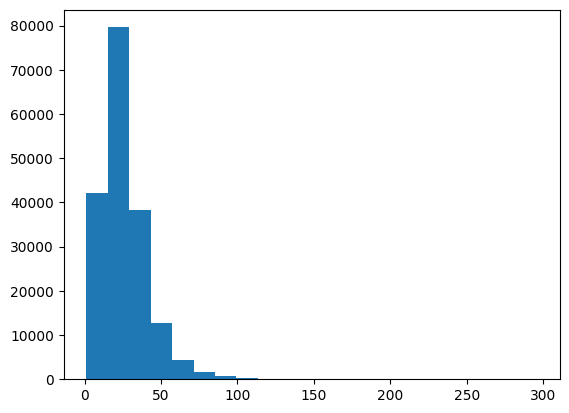

In [31]:
import matplotlib.pyplot as plt
plt.hist(sen_len,bins=21) # Checking the Sequence Length Distribution and getting most occurance  sequence length

Looks like the vast majority of sentences are between 0 and 50 tokens in length.

We can use NumPy's `percentile` to find the value which covers 95% of the sentence lengthsHow long of a sentesnces cover majority of the data ? (95%)

In [32]:
np.percentile(sen_len,95)

55.0

In [33]:
max(sen_len)   # max length sentence in training set

296

Creaating a text vectorizer layer

**Create text vectorize**

The vocabulary size of the PubMed 20k dataset as 68,000. So we'll use that as our max_tokens parameter.

In [34]:
max_tokens = 68000

In [36]:
from tensorflow.keras.layers import TextVectorization # TextVectorization is now in keras.layers.preprocessing
text_vectorizer = TextVectorization(max_tokens=max_tokens,standardize='lower_and_strip_punctuation',
                                    output_sequence_length=55)

In [37]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [38]:
# viewing vectorize training sentences
import random
target_sentence  = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
the purpose of this study was to compare therapeutic alliance in clients receiving cognitive behavioral therapy ( cbt ) for depression by telephone ( t-cbt ) or face-to-face ( ftf-cbt ) .

Length of text: 32

Vectorized text:
[[    2   754     4    23    17    10     6   237   478  5177     5  5632
    255   321   770    67  1355    11   266    22  1134 20071    16  3156
  30000     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [39]:
# Getting the vocabulary and showing most frequent and least frequest words in the vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
most_common = rct_20k_text_vocab[:5]
least_common = rct_20k_text_vocab[-5:]
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {most_common}")
print(f"Least common words in the vocabulary: {least_common}")

Number of words in vocabulary: 68000
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['httpsuploaduminacjpcgiopenbinctrctrcgifunctionbrowsactionbrowstypesummaryrecptnor000008238languagee', 'httpsregisterclinicaltrialsgov', 'httpsmartmicrosurgerycom', 'httpseudractemaeuropaeuindexhtml', 'httpseudractemaeuropaeu']


In [40]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 68000}

# Create custom text embedding

To create a richer numerical representation of our text, we can use an **embedding**.

The `input_dim` parameter defines the size of our vocabulary. And the `output_dim` parameter defines the dimension of the embedding output.

Once created, our embedding layer will take the integer outputs of our `text_vectorization` layer as inputs and convert them to feature vectors of size `output_dim`.

In [41]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim= 128,
                               mask_zero=True,
                               input_length=55)



print(f"Sentence before Vectorization : \n{target_sentence}\n")
vec_sentence = text_vectorizer([target_sentence])
print(f"Sentence After vectorization :\n {vec_sentence}\n")
embed_sentence = token_embed(vec_sentence)
print(f"Embedding Sentence :\n{embed_sentence}\n")

Sentence before Vectorization : 
the purpose of this study was to compare therapeutic alliance in clients receiving cognitive behavioral therapy ( cbt ) for depression by telephone ( t-cbt ) or face-to-face ( ftf-cbt ) .

Sentence After vectorization :
 [[    2   754     4    23    17    10     6   237   478  5177     5  5632
    255   321   770    67  1355    11   266    22  1134 20071    16  3156
  30000     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Embedding Sentence :
[[[ 0.04667893 -0.03171555 -0.04535919 ...  0.0018455  -0.00815983
    0.02371644]
  [ 0.00454547 -0.00164676 -0.02615609 ...  0.01364887  0.02144558
   -0.03244857]
  [-0.00535437  0.01759768 -0.03528374 ...  0.02629639  0.03365723
    0.01808579]
  ...
  [ 0.04237247 -0.03857632 -0.02006659 ... -0.02306679  0.00469425
   -0.04876305]
  [ 0.04237247 -0.03857632 -0.02006659 ... -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [43]:
# Turn our data into TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot.toarray())) # Convert sparse matrix to dense numpy array
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot.toarray())) # Convert sparse matrix to dense numpy array
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot.toarray())) # Convert sparse matrix to dense numpy array

In [44]:
len(train_dataset) , train_dataset

(180040,
 <_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>)

In [45]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

**Model 1: Conv1D with token embedding**

All of our deep models will follow a similar structure:

Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)

In [46]:
inputs = layers.Input(shape = (1,),dtype = tf.string)
text_vector = text_vectorizer(inputs)
embed = token_embed(text_vector)
x = layers.Conv1D(filters = 64, kernel_size= 5, padding="same",activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.01))(embed)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes,activation="softmax")(x)

model = tf.keras.Model(inputs,outputs)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 55)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 55, 128)             │       8,704,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 55, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,745,349 (33.36 MB)

 Trainable params: 8,745,349 (33.36 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
len(train_dataset)

5627

In [48]:
model.compile(optimizer='Adam', loss="categorical_crossentropy", metrics=["accuracy"])

In [49]:
model_1_history =  model.fit(train_dataset,
                             steps_per_epoch=int(0.1 * len(train_dataset)),
                             epochs = 10,
                             validation_data = valid_dataset,
                             validation_steps=int(0.1 * len(valid_dataset)),)

Epoch 1/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 87s 152ms/step - accuracy: 0.5073 - loss: 1.4226 - val_accuracy: 0.7507 - val_loss: 0.7760
Epoch 2/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 93s 165ms/step - accuracy: 0.7502 - loss: 0.7854 - val_accuracy: 0.7832 - val_loss: 0.6970
Epoch 3/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 82s 145ms/step - accuracy: 0.7620 - loss: 0.7238 - val_accuracy: 0.7889 - val_loss: 0.6590
Epoch 4/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 82s 146ms/step - accuracy: 0.7706 - loss: 0.6894 - val_accuracy: 0.7886 - val_loss: 0.6449
Epoch 5/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 86s 153ms/step - accuracy: 0.7773 - loss: 0.6831 - val_accuracy: 0.7969 - val_loss: 0.6336
Epoch 6/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 86s 153ms/step - accuracy: 0.7772 - loss: 0.6727 - val_accuracy: 0.7959 - val_loss: 0.6261
Epoch 7/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 84s 150ms/step - accuracy: 0.7906 - loss: 0.6398 - val_accuracy: 0.8055 - val_loss: 0.6116
Epoch 8/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 86s 153ms/step - accuracy: 0.7964 - loss: 0

In [51]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8114 - loss: 0.5851


[0.5885724425315857, 0.8115318417549133]

In [52]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model.predict(valid_dataset)
model_1_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


array([[5.65661132e-01, 2.30835289e-01, 2.24417485e-02, 1.64464906e-01,
        1.65969189e-02],
       [3.06670189e-01, 6.08430624e-01, 1.08235131e-03, 7.21266791e-02,
        1.16901668e-02],
       [2.02820122e-01, 1.50819877e-02, 1.15063100e-03, 7.80050516e-01,
        8.96696234e-04],
       ...,
       [1.95300221e-04, 1.72639883e-03, 4.55929637e-02, 2.30419857e-04,
        9.52254951e-01],
       [5.63084753e-03, 8.06830227e-02, 5.88298142e-02, 6.28553843e-03,
        8.48570824e-01],
       [1.24001585e-01, 7.67024934e-01, 1.17508061e-02, 2.30099894e-02,
        7.42126554e-02]], dtype=float32)

In [53]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

**Model_1 Results**

In [54]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 81.15318416523236,
 'precision': 0.8084634030673424,
 'recall': 0.8115318416523236,
 'f1': 0.8090492906565443}

# **Model 2: Feature extraction with pretrained token embedding (USE)**

Here We use Universal Sentence Encoder here from TF-HUB.

Since we're moving towards replicating the model architecture in Neural Networks for Joint Sentence Classification in Medical Paper Abstracts, it mentions they used a pretrained GloVe embedding as a way to initialise their token embeddings.

The model structure will look like:

*Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)*

In [55]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

Beautiful, now pretrained USE is downloaded and instantiated as a hub.KerasLayer instance, let's test it out on a random sentence

In [56]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
this change was significantly more evident in group a patients .

Sentence after embedding:
[-0.03269958 -0.02254067 -0.00969141  0.03898354 -0.06410518  0.02224733
  0.03026689 -0.03579187 -0.02515364  0.02603479  0.08659169  0.02956972
  0.08019351  0.06550868 -0.00116463  0.05165146 -0.08828314 -0.03741875
  0.02928751 -0.01907683  0.00289375  0.08729643 -0.00566383 -0.05317733
 -0.05160442 -0.00146239  0.02739275  0.04346065 -0.00302321  0.03214739] (truncated output)...

Length of sentence embedding:
512


In [58]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras import layers

class USE_Embedding_Layer(layers.Layer):
    def __init__(self, **kwargs):
        super(USE_Embedding_Layer, self).__init__(**kwargs)
        self.tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                                    trainable=False,
                                                    name="universal_sentence_encoder")

    def call(self, inputs):
        return self.tf_hub_embedding_layer(inputs)

# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
# Wrap tf_hub_embedding_layer within a custom layer
pretrained_embedding = USE_Embedding_Layer()(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
# x = layers.Dropout(0.2)(x)
outputs = layers.Dense(5, activation="softmax", kernel_regularizer=None)(x)
model_2 = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [59]:
# Get a summary of the model
model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None)                      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ use__embedding__layer                │ (None, 512)                 │               0 │
│ (USE_Embedding_Layer)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,309 (259.02 KB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
model_2_history =  model_2.fit(train_dataset,
                             steps_per_epoch=int(0.1 * len(train_dataset)),
                             epochs = 10,
                             validation_data = valid_dataset,
                             validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5966 - loss: 1.0718 - val_accuracy: 0.6938 - val_loss: 0.7777
Epoch 2/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7109 - loss: 0.7483 - val_accuracy: 0.7148 - val_loss: 0.7351
Epoch 3/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.7226 - loss: 0.7265 - val_accuracy: 0.7174 - val_loss: 0.7233
Epoch 4/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.7330 - loss: 0.7025 - val_accuracy: 0.7244 - val_loss: 0.6975
Epoch 5/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.7325 - loss: 0.6913 - val_accuracy: 0.7334 - val_loss: 0.6767
Epoch 6/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7346 - loss: 0.6898 - val_accuracy: 0.7420 - val_loss: 0.6699
Epoch 7/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.7501 - loss: 0.6553 - val_accuracy: 0.7537 - val_loss: 0.6508
Epoch 8/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.7548 - loss: 0.6567 - val_

In [61]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.7585 - loss: 0.6321


[0.633317768573761, 0.7601284384727478]

In [62]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step


array([[4.3354753e-01, 4.0830517e-01, 6.6177547e-04, 1.4777510e-01,
        9.7103780e-03],
       [3.7614509e-01, 5.2796394e-01, 1.9311822e-03, 9.2932008e-02,
        1.0277649e-03],
       [4.0652990e-01, 4.0768623e-02, 8.1535811e-03, 5.3572971e-01,
        8.8182501e-03],
       ...,
       [4.0459394e-04, 2.7327001e-04, 1.6250849e-02, 1.5542311e-04,
        9.8291588e-01],
       [3.2085956e-03, 1.8105440e-02, 2.1170047e-01, 8.5941388e-04,
        7.6612610e-01],
       [4.3532167e-02, 8.6231887e-01, 8.1115492e-02, 1.0815576e-03,
        1.1951913e-02]], dtype=float32)

In [63]:

# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

**Model_2 Results**

In [64]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 76.01284257910764,
 'precision': 0.7552457146250758,
 'recall': 0.7601284257910764,
 'f1': 0.7558829941236223}

# **Model 3: Conv1D with character embedding**

**Creating a character-level tokenizer**

The Neural Networks for Joint Sentence Classification in Medical Paper Abstracts paper mentions their model uses a hybrid of token and character embeddings.

The difference between a character and token embedding is that the **character embedding** is created using sequences split into characters (e.g. hello -> [h, e, l, l, o]) where as a **token embedding** is created on sequences split into tokens.


Token level embeddings split sequences into tokens (words) and embeddings each of them, character embeddings split sequences into characters and creates a feature vector for each.


Before we can vectorize our sequences on a character-level we'll need to split them into characters. Let's write a function to do so

In [65]:
" ".join(list(train_sentences[0]))

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   6   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   1 2   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [66]:
def split_chars(text):
  return " ".join(list(text))

split_chars(random_training_sentence)

't h i s   c h a n g e   w a s   s i g n i f i c a n t l y   m o r e   e v i d e n t   i n   g r o u p   a   p a t i e n t s   .'

In [67]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   6   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   1 2   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [68]:
train_chars[:15]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   6   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   1 2   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   1 2 5   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   1 : 1   ;   6 3   r e c e i v e d   7 . 5   m g / d a y   o f   p r e d n i s o l o n e   a n d   6 2   r e c e i v e d   p l a c e b o   f o r   6   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s 

In [69]:
# Check the Avrage Char Length in the training Sentences
char_lens = [len(sentence) for sentence in train_sentences]
avg_char_lens = sum(char_lens)/len(char_lens)
avg_char_lens

152.006276383026

(array([1.4099e+04, 5.4222e+04, 5.5798e+04, 3.2296e+04, 1.4142e+04,
        5.6230e+03, 2.1610e+03, 9.2500e+02, 3.9600e+02, 1.7400e+02,
        8.8000e+01, 5.1000e+01, 2.1000e+01, 1.4000e+01, 8.0000e+00,
        9.0000e+00, 6.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   2.  ,   60.08,  118.16,  176.24,  234.32,  292.4 ,  350.48,
         408.56,  466.64,  524.72,  582.8 ,  640.88,  698.96,  757.04,
         815.12,  873.2 ,  931.28,  989.36, 1047.44, 1105.52, 1163.6 ,
        1221.68, 1279.76, 1337.84, 1395.92, 1454.  ]),
 <BarContainer object of 25 artists>)

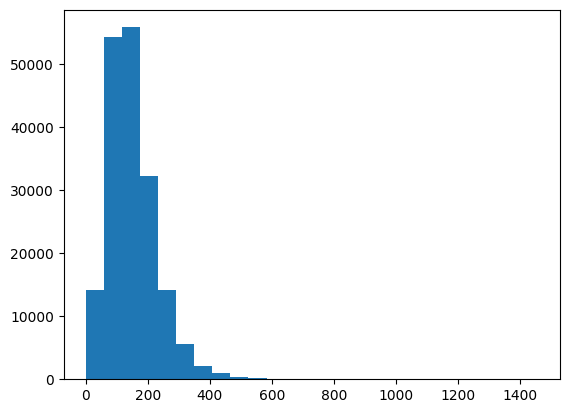

In [70]:
import matplotlib.pyplot as plt
plt.hist(char_lens,bins =25)

It seems most of the sequences are between 0 and 200 characters long.

Let's use NumPy's percentile to figure out what length covers 95% of our sequences

In [71]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

296

In [72]:
random.choice(train_sentences)

'this trial included a relatively small sample .'

In [73]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [74]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [75]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 38
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['8', '7', 'z', 'q', 'j']


In [76]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
i n t e n t i o n   t o   v i s i t   t h e   w e b s i t e   (   s t u d y   1   )   ,   c l i c k i n g   o n   t h e   l i n k   t o   v i s i t   t h e   w e b s i t e   (   s t u d i e s   2   a n d   3   )   a n d   t h e   n u m b e r   o f   p a g e s   v i s i t e d   o n   t h e   w e b s i t e   (   s t u d y   3   )   .

Length of chars: 130

Vectorized chars:
[[ 4  6  3  2  6  3  4  7  6  3  7 21  4  9  4  3  3 13  2 20  2 22  9  4
   3  2  9  3 16 10 19 24 11 12  4 11 27  4  6 18  7  6  3 13  2 12  4  6
  27  3  7 21  4  9  4  3  3 13  2 20  2 22  9  4  3  2  9  3 16 10  4  2
   9 25  5  6 10 28  5  6 10  3 13  2  6 16 15 22  2  8  7 17 14  5 18  2
   9 21  4  9  4  3  2 10  7  6  3 13  2 20  2 22  9  4  3  2  9  3 16 10
  19 28  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0 

# **Creating a character-level embedding**

We've got a way to vectorize our character-level sequences, now's time to create a character-level embedding.


The input dimension (`input_dim`) will be equal to the number of different characters in our `char_vocab` (28). And since we're following the structure of the model in Figure 1 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts, the output dimension of the character embedding (`output_dim`) will be 25.

In [77]:
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                              output_dim= 25,
                              mask_zero= True,
                              name= "char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
i n t e n t i o n   t o   v i s i t   t h e   w e b s i t e   (   s t u d y   1   )   ,   c l i c k i n g   o n   t h e   l i n k   t o   v i s i t   t h e   w e b s i t e   (   s t u d i e s   2   a n d   3   )   a n d   t h e   n u m b e r   o f   p a g e s   v i s i t e d   o n   t h e   w e b s i t e   (   s t u d y   3   )   .

Embedded chars (after vectorization and embedding):
[[[-0.03064638  0.03699075  0.02238566 ...  0.03245895  0.03631402
   -0.03910057]
  [-0.00825796 -0.004566    0.03579607 ...  0.018183    0.04555133
   -0.01707191]
  [ 0.03818103 -0.01497211  0.01784765 ...  0.01272618  0.0168123
   -0.04768001]
  ...
  [-0.01311821  0.02561471  0.03932801 ... -0.02179231 -0.03888666
    0.02616385]
  [-0.01311821  0.02561471  0.03932801 ... -0.02179231 -0.03888666
    0.02616385]
  [-0.01311821  0.02561471  0.03932801 ... -0.02179231 -0.03888666
    0.02616385]]]

Character embedding shape: (1, 296, 25)


Before fitting this model on the data, we'll create char-level batched `*PrefetchedDataset*`'s.

In [79]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot.toarray())).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot.toarray())).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# **Building a Conv1D model to fit on character embeddings**

Now we've got a way to turn our character-level sequences into numbers (`char_vectorizer`) as well as numerically represent them as an embedding (`char_embed`) let's test how effective they are at encoding the information in our sequences by creating a character-level sequence model.

The model will have the same structure as our custom token embedding model (`model_1`) except it'll take character-level sequences as input instead of token-level sequences.

*Input (character-level text) -> Tokenize -> Embedding -> Layers (Conv1D, GlobalMaxPool1D) -> Output (label probability)*

In [80]:
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.01))(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "model_3_conv1D_char_embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char_vectorizer (TextVectorization)  │ (None, 296)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ char_embed (Embedding)               │ (None, 296, 25)             │           1,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 296, 64)             │           8,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,139 (39.61 KB)

 Trainable params: 10,139 (39.61 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=10,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.4184 - loss: 1.5060 - val_accuracy: 0.5672 - val_loss: 1.1710
Epoch 2/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.5520 - loss: 1.1528 - val_accuracy: 0.6077 - val_loss: 1.0655
Epoch 3/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.5981 - loss: 1.0666 - val_accuracy: 0.6453 - val_loss: 1.0039
Epoch 4/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.6355 - loss: 1.0044 - val_accuracy: 0.6516 - val_loss: 0.9662
Epoch 5/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.6467 - loss: 0.9697 - val_accuracy: 0.6782 - val_loss: 0.9464
Epoch 6/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - accuracy: 0.6649 - loss: 0.9493 - val_accuracy: 0.6775 - val_loss: 0.9145
Epoch 7/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.6830 - loss: 0.9123 - val_accuracy: 0.6905 - val_loss: 0.8875
Epoch 8/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.6876 - loss: 0.8959 - 

In [ ]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

In [ ]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

In [ ]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

**Model_3 Results**

In [ ]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

# **Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)**

In moving closer to build a model similar to the one in Figure 1 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts, it's time we tackled the hybrid token embedding layer they speak of.

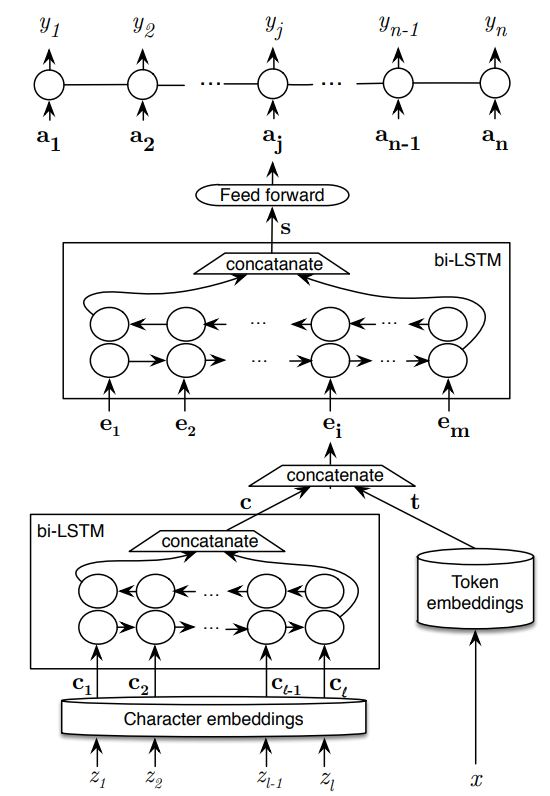

* This hybrid token embedding layer is a combination of token embeddings and character embeddings. In other words, they create a stacked embedding to represent sequences before passing them to the sequence label prediction layer

To start replicating (or getting close to replicating) the model in Figure 1, we're going to go through the following steps:

1. Create a token-level model (similar to model_1)
2. Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
3. Combine (using layers.Concatenate) the outputs of 1 and 2
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [83]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras import layers

# Wrap tf_hub_embedding_layer in a custom layer
class USE_Embedding_Layer(layers.Layer):
    def __init__(self, **kwargs):
        super(USE_Embedding_Layer, self).__init__(**kwargs)
        self.tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                                    trainable=False,
                                                    name="universal_sentence_encoder")

    def call(self, inputs):
        return self.tf_hub_embedding_layer(inputs)

# Token_level Model (using Pretrained -- Universal Sentence Encoder)
token_inputs = layers.Input(shape = [], dtype= tf.string, name = "token_input")
# Pass token_inputs through the custom layer
token_embedding = USE_Embedding_Layer()(token_inputs)
token_dense = layers.Dense(128,activation="relu")(token_embedding)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_dense)

2 # char_level Model
char_inputs = layers.Input(shape=(1,), dtype= tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embedding = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25,activation="relu"))(char_embedding)
char_model = tf.keras.Model(inputs= char_inputs,    # char_dense = layers.Dense(128,activation="relu")(char_bilstm)
                            outputs =char_bi_lstm)


3 # Now Concatenate token_model and char_model
concat_layer = layers.Concatenate(name = "token_char_hybrid")([token_model.output,
                                                               char_model.output])

4 # Add Some Layer on top of concat_layer
concat_dropout = layers.Dropout(0.5)(concat_layer)
concat_dense = layers.Dense(256,activation="relu")(concat_dropout)
final_dropout = layers.Dropout(0.2)(concat_dense)
output_layer = layers.Dense(num_classes,activation="softmax")(final_dropout)

model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                         outputs = output_layer,
                         name="model_4_token_and_char_embeddings")

In [84]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_input (InputLayer)  │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_vectorizer           │ (None, 296)            │              0 │ char_input[0][0]       │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ use__embedding__layer_1   │ (None, 512)            │              0 │ token_input[0][0]      │
│ (USE_Embedding_Layer)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_embed (Embedding)    │ (None, 296, 25)        │          1,750 │ char_vectorizer[1][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_2 (NotEqual)    │ (None, 296)            │              0 │ char_vectorizer[1][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │         65,664 │ use__embedding__layer… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 50)             │         10,200 │ char_embed[1][0],      │
│ (Bidirectional)           │                        │                │ not_equal_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_hybrid         │ (None, 178)            │              0 │ dense_4[0][0],         │
│ (Concatenate)             │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 178)            │              0 │ token_char_hybrid[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 256)            │         45,824 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 5)              │          1,285 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 124,723 (487.20 KB)

 Trainable params: 124,723 (487.20 KB)

 Non-trainable params: 0 (0.00 B)

**Visualize the Hybrid Model**

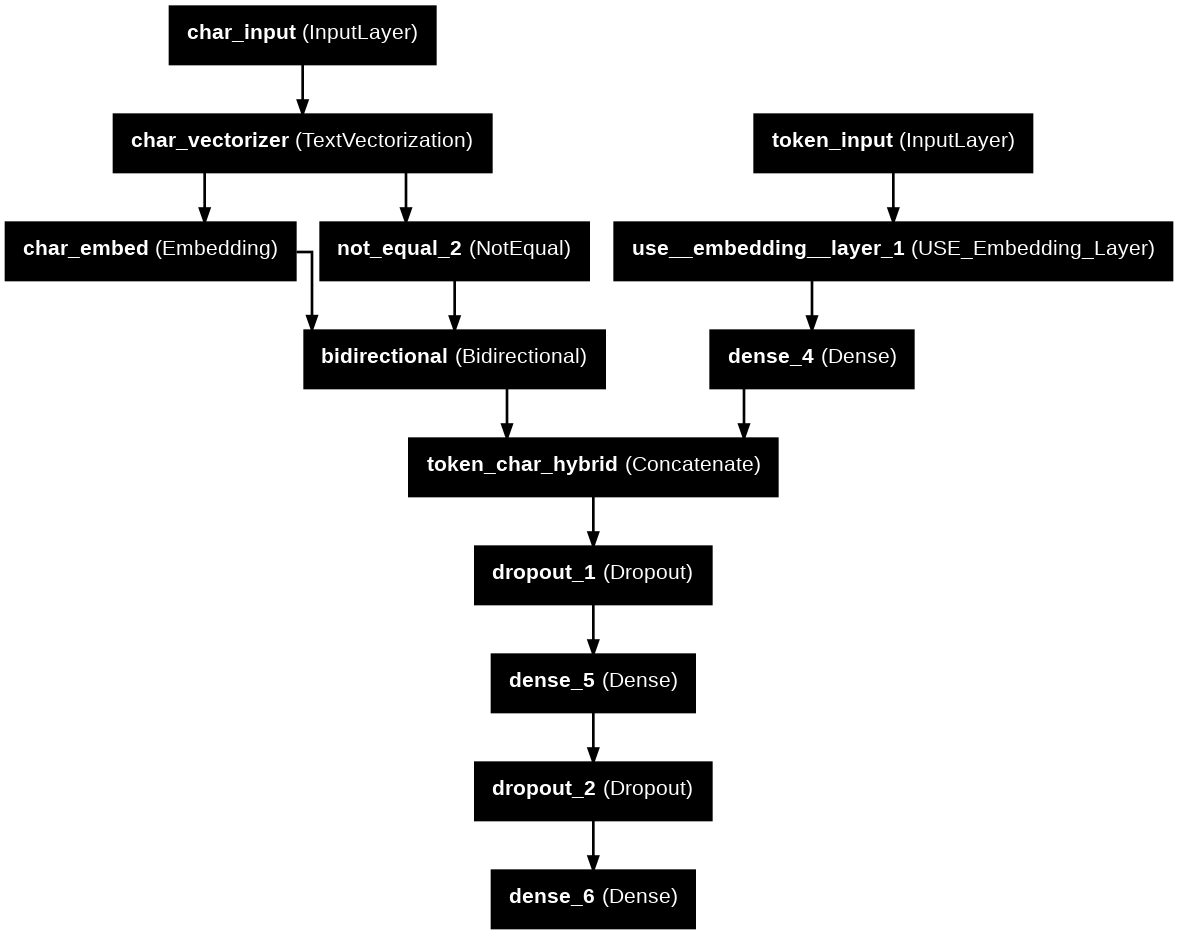

In [85]:
tf.keras.utils.plot_model(
    model_4, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [86]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [88]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
# Convert train_labels_one_hot to a dense NumPy array
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot.toarray()) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
# Convert val_labels_one_hot to a dense NumPy array
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot.toarray())
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [89]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=10,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 262s 450ms/step - accuracy: 0.5596 - loss: 1.0796 - val_accuracy: 0.7051 - val_loss: 0.7508
Epoch 2/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 227s 404ms/step - accuracy: 0.5927 - loss: nan - val_accuracy: 0.1157 - val_loss: nan
Epoch 3/10
304/562 ━━━━━━━━━━━━━━━━━━━━ 1:24 328ms/step - accuracy: 0.1227 - loss: nan

In [ ]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

In [ ]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

In [ ]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

In [ ]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

# **Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings**

As it's a Sequential classification problem the sequences come in a particular order. Like OBJECTIVE comes first rather then CONCLUSION.

Abstracts typically come in a sequential order, such as:

* OBJECTIVE ...
* METHODS ...
* METHODS ...
* METHODS ...
* RESULTS ...
* CONCLUSIONS ...

Or,

* BACKGROUND ...
* OBJECTIVE ...
* METHODS ...
* METHODS ...
* RESULTS ...
* CONCLUSIONS ...

Here we do some Feature Engineering so that our model can learn the order sentences in the Abstract and know where the sentence appear in the Abstract. The "`line_number`" and "`total_lines`" columns are features which didn't necessarily come with the training data but can be passed to our model as a **positional embedding**.

**Positional Embedding make your model include the information about order of the input. The positional encoding step allows the model to recognize which part of the sequence an input belongs to.**

But to avoid our model thinking a line with "`line_number`"=5 is five times greater than a line with "`line_number`"=1, we'll use one-hot-encoding to encode our "`line_number`" and "`total_lines`" features.

That is why we have to use one-hot encoding. We use tf.one_hot for it.

In [ ]:
# Checking the Distribution of line Number in The data.
train_df["line_number"].value_counts()

In [ ]:
# Check the distribution of line numbers
train_df.line_number.plot.hist()

Looking at the distribution of the "line_number" column, it looks like the majority of lines have a position of 15 or less.

Knowing this, let's set the depth parameter of tf.one_hot to 15.

In [ ]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(),depth= 15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(),depth= 15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(),depth= 15)

In [ ]:
# Check one-hot encoded "line_number" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

We could create a one-hot tensor which has room for all of the potential values of "line_number" (depth=30), however, this would end up in a tensor of double the size of our current one (depth=15) where the vast majority of values are 0. Plus, only ~2,000/180,000 samples have a "line_number" value of over 15. So we would not be gaining much information about our data for doubling our feature space. This kind of problem is called the curse of dimensionality. However, since this we're working with deep models, it might be worth trying to throw as much information at the model as possible and seeing what happens. I'll leave exploring values of the depth parameter as an extension.

We can do the same above process for the total line also in data.

In [ ]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

In [ ]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();

It shows that majority of data has line number below 20. We can perform numpy percentile to check this.

In [ ]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of samples

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]